# **Multi-class Food Vision**
**# Create a Web App to classify 10 types of Food.** 


***Food classes:
'chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi' ***

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random

In [2]:
tf.random.set_seed(42)

# **Dowload dataset and extract it**

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-07-19 16:33:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   207MB/s    in 2.4s    

2022-07-19 16:33:30 (207 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

# **Look into directory size and structure**

In [5]:
import os

for dpath, dname, fname in os.walk("/content/10_food_classes_all_data"):
  print(f"There are {len(dname)} directories and {len(fname)} images in '{dpath}'.")

There are 2 directories and 0 images in '/content/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/10_food_classes_all_data/train'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train

# **Extracting Class Names**

In [6]:
import pathlib

path = pathlib.Path("/content/10_food_classes_all_data/train")

class_names = list(sorted(item.name for item in path.glob('*')))
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# **Visualise Random Samples**

In [7]:
def view_random_sample(target_dir, target_class):
  target_path = target_dir + "/" + target_class
  image = random.sample(os.listdir(target_path), 1)
  #print(image)
  img = plt.imread(target_path + "/" + image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

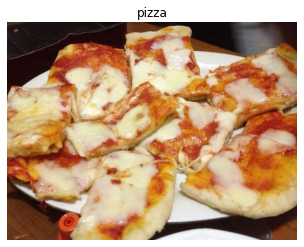

In [8]:
view_random_sample("/content/10_food_classes_all_data/train/", "pizza")

# **View many samples at once**

In [9]:
def view_multiple_samples(target_dir, n):
  plt.figure(figsize=(30,17))
  index = 31
  for i in range(1, n+1):
    plt.subplot(1, n, i)
    target_class = class_names[index%10]
    view_random_sample(target_dir, target_class)
    index = index+1

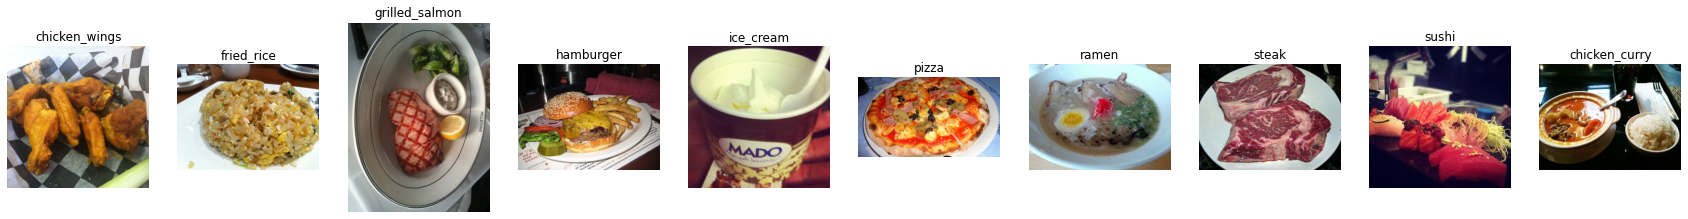

In [10]:
view_multiple_samples("/content/10_food_classes_all_data/train/", 10)

# **Preprocessing Data**

In [11]:
from tensorflow.python.ops.gen_batch_ops import batch
train_datagen = ImageDataGenerator(rescale=1/255.)

valid_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = "/content/10_food_classes_all_data/train"
test_dir = "/content/10_food_classes_all_data/test"

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical",
                                               shuffle=True)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical",
                                               shuffle=True)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# **Let's extract features from EfficientNet model from tfhub**

In [12]:
import tensorflow_hub as hub
efficientnet_model_feature = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                                            input_shape=(224,224,3),
                                            trainable=False,
                                            name = "EfficientNet")

# **Build the model**

In [13]:
model = tf.keras.Sequential([
  efficientnet_model_feature,
  tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history = model.fit(train_data,
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = valid_data,
          validation_steps = len(valid_data))

Epoch 1/5
 60/235 [======>.......................] - ETA: 4:03 - loss: 1.3578 - accuracy: 0.6219

KeyboardInterrupt: ignored

# **Plotting Loss Curves**

In [ ]:
def plot_loss_curves(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(len(history.history["loss"]))
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.xlabel("epochs")
  plt.title("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.xlabel("epochs")
  plt.title("Accuracy")
  plt.legend()


In [ ]:
plot_loss_curves(history)

# **Let's load and prepare a custom image**

In [ ]:
def load_and_prep(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img)

  img = tf.image.resize(img, size=[224,224])
  img = img/ 255.
  return img

# **Let's predict on a custom image**

In [ ]:
def pred_and_plot(model, image_path):
  img = load_and_prep(image_path)

  pred = model.predict(tf.expand_dims(img, axis=0))

  pred_label = class_names[tf.argmax(pred[0])]

  print(f"The predicted class is {pred_label}")

  plt.imshow(img)
  plt.title(pred_label)
  plt.axis(False)
  return pred_label



In [ ]:
class_names

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

In [ ]:
pred_and_plot(model, "03-sushi.jpeg")

# **Hurrah!!!!!!!!!!!!!**

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg

In [ ]:
pred_and_plot(model, "03-hamburger.jpeg")

In [ ]:
model.save("FoodVision10.h5")

# **Creating a WebApp**

In [ ]:
!pip install flask --quiet
!pip install flask-ngrok --quiet
print("Completed!")

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz

In [ ]:
!tar -xvf /content/ngrok-stable-linux-amd64.tgz

In [ ]:
!./ngrok authtoken 2BxTTMN1iLbyEs5lsY6qtcGrSAd_7xYngAGdEtRozKR1Yg7ih

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)


model2 = tf.keras.models.load_model(
       ('/content/FoodVision10.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

	
# routes
@app.route("/", methods=['GET', 'POST'])
def main():
	return render_template("index.html")

@app.route("/submit", methods = ['GET', 'POST'])
def get_output():
	if request.method == 'POST':
		img = request.files['my_image']

    #Save image to static folder
		img_path = "static/" + img.filename	
		img.save(img_path)
    
    #Call model.predict and get the predicted label
		p = pred_and_plot(model2, img_path)
	return render_template("index.html", prediction = p, img_path = img_path)
  

if __name__ =='__main__':
	app.run()